# 🧩 Named Entity Recognition (NER)

> **Objective:**  
> Automatically identify and classify **named entities** in text — such as **people**, **locations**, **organizations**, **dates**, and more.

NER helps convert unstructured text into structured information,  
which is essential for **information extraction**, **question answering**, **summarization**, and **search systems**.

---

## 📘 1. What is NER?

**Definition:**
$$
\text{NER}(w_i) = \text{classify}(w_i, \text{context}) \in \{\text{PERSON, ORG, LOC, DATE, TIME, MISC}\}
$$

Each recognized entity is labeled with a **semantic class**.

**Example:**
> “M.S. Dhoni led India to victory in the 2011 World Cup held in Mumbai.”

| Entity | Label | Meaning |
|---------|--------|----------|
| M.S. Dhoni | PERSON | Individual name |
| India | GPE | Country / location |
| 2011 | DATE | Temporal entity |
| World Cup | EVENT | Named event |
| Mumbai | GPE | Location |


In [2]:
paragraph = """
When you step into any challenge, you must bring one thing above all — consistency in your actions.
Success is not a sudden peak — it’s a steady climb built on daily habits.
You don’t wake up one morning and find you’re great; you become great because you kept showing up, kept trying, and kept learning.
M.S. Dhoni led India to victory in the 2011 World Cup held in Mumbai.
"""

In [3]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk, sent_tokenize

nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('words', quiet=True)
nltk.download('maxent_ne_chunker', quiet=True)
nltk.download('maxent_ne_chunker_tab', quiet=True)

True

In [4]:
import matplotlib.pyplot as plt
from IPython.display import Markdown
# Take the last sentence (with named entities)
sentences = sent_tokenize(paragraph)
words = word_tokenize(sentences[-1])
tag_elements = pos_tag(words)

# Generate tree
ner_tree = ne_chunk(tag_elements)

# Show textual parse tree inline
display(Markdown("### 🧩 Named Entity Tree (Text View)"))
print(ner_tree.pformat())

### 🧩 Named Entity Tree (Text View)

(S
  (PERSON Dhoni/NNP)
  led/VBD
  (GPE India/NNP)
  to/TO
  victory/NN
  in/IN
  the/DT
  2011/CD
  World/NNP
  Cup/NNP
  held/VBD
  in/IN
  (GPE Mumbai/NNP)
  ./.)


In [5]:
for i, s in enumerate(sentences, 1):
    tokens = word_tokenize(s)
    tags = pos_tag(tokens)
    tree = ne_chunk(tags, binary=False)
    print(f"\nSentence {i}: {s}\n{'-'*len(s)}")
    print(tree)



Sentence 1: 
When you step into any challenge, you must bring one thing above all — consistency in your actions.
----------------------------------------------------------------------------------------------------
(S
  When/WRB
  you/PRP
  step/VBP
  into/IN
  any/DT
  challenge/NN
  ,/,
  you/PRP
  must/MD
  bring/VB
  one/CD
  thing/NN
  above/IN
  all/DT
  —/JJ
  consistency/NN
  in/IN
  your/PRP$
  actions/NNS
  ./.)

Sentence 2: Success is not a sudden peak — it’s a steady climb built on daily habits.
-------------------------------------------------------------------------
(S
  (GPE Success/NNP)
  is/VBZ
  not/RB
  a/DT
  sudden/JJ
  peak/NN
  —/NN
  it/PRP
  ’/VBZ
  s/VBZ
  a/DT
  steady/JJ
  climb/NN
  built/VBN
  on/IN
  daily/JJ
  habits/NNS
  ./.)

Sentence 3: You don’t wake up one morning and find you’re great; you become great because you kept showing up, kept trying, and kept learning.
--------------------------------------------------------------------------------------

## 🧩 2. NLTK’s `ne_chunk()` Function

`ne_chunk()` uses a **trained statistical model** to detect entities from POS-tagged text.  
It outputs a **tree structure** where each named entity is a subtree.

Example subtree:

```bash
(NE PERSON
(M.S. NNP)
(Dhoni NNP))
```


---

### 💡 Types of Named Entities (Common Labels)

| Label | Entity Type | Example |
|--------|--------------|----------|
| PERSON | Human names | M.S. Dhoni |
| ORGANIZATION | Groups or institutions | BCCI, Infosys |
| GPE | Geo-political entity | India, Mumbai |
| DATE | Date or year | 2011 |
| TIME | Specific time | 6:30 p.m. |
| EVENT | Named event | World Cup |
| MONEY | Monetary value | ₹500, $200 |
| PERCENT | Percentage | 90% |
| FACILITY | Physical structure | Eden Gardens |
| LOC | Non-GPE location | Bay of Bengal |

---

In [6]:
from nltk import tree

# Extract named entities as (NE Label, Words)
def extract_named_entities(text):
    entities = []
    for sent in sent_tokenize(text):
        tokens = word_tokenize(sent)
        tagged = pos_tag(tokens)
        chunks = ne_chunk(tagged, binary=False)
        for subtree in chunks:
            if hasattr(subtree, 'label'):
                entity = " ".join([token for token, pos in subtree.leaves()])
                label = subtree.label()
                entities.append((entity, label))
    return entities


entities = extract_named_entities(paragraph)

for e, label in entities:
    print(f"{e:>20}  →  {label}")

             Success  →  GPE
               Dhoni  →  PERSON
               India  →  GPE
              Mumbai  →  GPE


# ⚠️ NER Model Limitations (Why 2011 and World Cup were Missed)

After running NLTK’s Named Entity Recognizer, the output was:

```text
Success → GPE
Dhoni → PERSON
India → GPE
Mumbai → GPE
```


But expected entities like **“2011” (DATE)** and **“World Cup” (EVENT)** were missing.  
Let’s understand **why** ⬇️

---

## 🧠 Root Cause Analysis

### 1️⃣ **Outdated Statistical Model**
NLTK’s `maxent_ne_chunker` is based on **early 2000s rule-based and maximum entropy models**.  
It recognizes only limited classes — typically:
$$
\{\text{PERSON},\ \text{ORGANIZATION},\ \text{GPE},\ \text{LOCATION}\}
$$
Modern entity types like `EVENT`, `DATE`, or `TIME` are not always captured.

---

### 2️⃣ **Context-Free Numeric Tokens**
The token **“2011”** is tagged as:
$$
\text{2011} \to \text{CD (Cardinal Number)}
$$
Since NLTK’s chunker does not treat standalone `CD` tokens as `DATE`, it ignores them unless
they occur in explicit contexts (e.g., “in 2011”, “since 2011”).

---

### 3️⃣ **Multi-word Named Entities Missing**
NLTK often fails to merge **multi-word entities** (like “World Cup”)  
because its chunker is not trained on modern bigram or phrase embeddings.

$$
\text{"World Cup"} \nrightarrow \text{EVENT}
$$
Instead, it gets split into:
$$
\text{World} \to \text{NNP}, \quad \text{Cup} \to \text{NNP}
$$
and thus no NER label is applied.

---

### 4️⃣ **False Positive: “Success → GPE”**
Words at sentence beginnings that are capitalized can be **misclassified** as `GPE` (geo-political entity).  
This happens because the model lacks context embeddings — it guesses based on capitalization patterns.

---

### 🧩 Summary

| Issue | Cause | Example |
|--------|--------|----------|
| 2011 not recognized | NLTK doesn’t treat `CD` as `DATE` | “2011 → CD” |
| World Cup missed | Multi-word event not in model | “World Cup → NNP NNP” |
| Success → GPE | Capitalization confusion | “Success” at start of sentence |
| Model Limitations | Trained on old corpora | Fails on modern text |

---


# ✅ Modern Solution: spaCy Named Entity Recognition

In [7]:
!pip install spacy

In [8]:
# ✅ Modern Solution: spaCy Named Entity Recognition

# ✅ Import the spaCy library — one of the most powerful NLP frameworks.
# It provides state-of-the-art pipelines for tokenization, POS tagging, parsing, and Named Entity Recognition (NER).
import spacy
from spacy.cli import download

download("en_core_web_sm")

# 🧠 Load spaCy’s small English language model.
# This model ("en_core_web_sm") is a pre-trained statistical + neural model that understands English grammar and entities.
# It includes:
# - Tokenizer
# - POS tagger
# - Dependency parser
# - NER component
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
# 📝 Define the input text — here, your motivational paragraph inspired by M.S. Dhoni.
# This text contains potential named entities such as:
# - "M.S. Dhoni" → PERSON
# - "India" → GPE (Geo-Political Entity)
# - "2011" → DATE
# - "World Cup" → EVENT
# - "Mumbai" → GPE

text = """
When you step into any challenge, you must bring one thing above all — consistency in your actions.
Success is not a sudden peak — it’s a steady climb built on daily habits.
M.S. Dhoni led India to victory in the 2011 World Cup held in Mumbai.
"""

# ⚙️ Pass the text through spaCy’s NLP pipeline using the `nlp()` function.
# This automatically performs:
#   1. Tokenization (splitting text into linguistic units)
#   2. POS tagging (assigning parts of speech)
#   3. Dependency parsing (syntactic relationships)
#   4. Named Entity Recognition (NER) — identifying and classifying named entities.
# The result is a spaCy "Doc" object — a container holding tokens, entities, and linguistic annotations.
doc = nlp(text)

# 📦 Print a header line to indicate that the next lines will display recognized entities.
print("📦 spaCy NER Results:\n")

# 🔍 Loop through each detected named entity in the document.
# spaCy stores all recognized entities in `doc.ents`.
# Each entity object has useful attributes:
#   - ent.text  → the exact substring from the text (e.g., "M.S. Dhoni")
for ent in doc.ents:
    # Extract entity details
    entity_text = ent.text                # The named entity (e.g., "M.S. Dhoni")
    entity_label = ent.label_             # The entity type (e.g., PERSON, GPE, DATE)
    start_char = ent.start_char           # Starting character index in the text
    end_char = ent.end_char               # Ending character index in the text
    
    # 🧩 Find the sentence that contains this entity
    # ent.sent returns the full sentence (as a Span object) in which the entity occurs
    sentence_context = ent.sent.text.strip()

    # 🧾 Print entity details in a structured, readable format
    print(f"Entity     : {entity_text}")
    print(f"Label      : {entity_label}")
    print(f"Start-End  : [{start_char}–{end_char}]")
    print(f"Sentence   : {sentence_context}")
    print("-" * 80)


📦 spaCy NER Results:

Entity     : one
Label      : CARDINAL
Start-End  : [50–53]
Sentence   : When you step into any challenge, you must bring one thing above all — consistency in your actions.
--------------------------------------------------------------------------------
Entity     : Success
Label      : ORG
Start-End  : [101–108]
Sentence   : Success is not a sudden peak — it’s a steady climb built on daily habits.
--------------------------------------------------------------------------------
Entity     : daily
Label      : DATE
Start-End  : [161–166]
Sentence   : Success is not a sudden peak — it’s a steady climb built on daily habits.
--------------------------------------------------------------------------------
Entity     : M.S. Dhoni
Label      : PERSON
Start-End  : [175–185]
Sentence   : M.S. Dhoni led India to victory in the 2011 World Cup held in Mumbai.
--------------------------------------------------------------------------------
Entity     : India
Label      : GPE


### 💡 Explanation Summary

| Line                                        | Purpose                                                                        |
| ------------------------------------------- | ------------------------------------------------------------------------------ |
| `import spacy`                              | Import the spaCy NLP framework.                                                |
| `nlp = spacy.load("en_core_web_sm")`        | Load the pre-trained English NLP model.                                        |
| `text = """..."""`                          | Define the input paragraph (Dhoni’s speech).                                   |
| `doc = nlp(text)`                           | Process the text → returns a rich `Doc` object with tokens, POS, and entities. |
| `for ent in doc.ents:`                      | Iterate over detected named entities.                                          |
| `ent.text`                                  | Extracts the entity phrase as it appears in the text                           |    
| `ent.label_`                                | The entity category label (e.g., PERSON, GPE, EVENT, DATE)                     |
| `ent.start_char` / `ent.end_char`           | Character-level indices of the entity span in the text                         |
| `ent.sent.text`                             | Retrieves the full sentence where the entity occurs                            |
| `print("-"*80)`                             | Prints a visual separator for cleaner console output                           |


## 📊 NER Results → DataFrame (spaCy)

We’ll collect each named entity with:
- **Entity text**
- **Label** (PERSON, GPE, DATE, EVENT, …)
- **Character span** `[start, end)`
- **Sentence context**

Then we’ll display it as a **Pandas DataFrame**


In [10]:
import pandas as pd
# Build records
records = []
for ent in doc.ents:
    records.append({
        "entity": ent.text,
        "label": ent.label_,
        "start_char": ent.start_char,
        "end_char": ent.end_char,
        "sentence": ent.sent.text.strip()
    })

# Create DataFrame
df_ents = pd.DataFrame(records, columns=["entity", "label", "start_char", "end_char", "sentence"])

# Sort (optional): by appearance in text
df_ents = df_ents.sort_values(by="start_char", ascending=True).reset_index(drop=True)

display(df_ents.head(7))

,entity,label,start_char,end_char,sentence
0,one,CARDINAL,50,53,"When you step into any challenge, you must bri..."
1,Success,ORG,101,108,Success is not a sudden peak — it’s a steady c...
2,daily,DATE,161,166,Success is not a sudden peak — it’s a steady c...
3,M.S. Dhoni,PERSON,175,185,M.S. Dhoni led India to victory in the 2011 Wo...
4,India,GPE,190,195,M.S. Dhoni led India to victory in the 2011 Wo...
5,the 2011 World Cup,EVENT,210,228,M.S. Dhoni led India to victory in the 2011 Wo...
6,Mumbai,GPE,237,243,M.S. Dhoni led India to victory in the 2011 Wo...


## 📈 Named Entity Frequency Visualization

Let’s visualize how many entities were detected per category (e.g., PERSON, GPE, DATE, EVENT).  
This helps us quickly understand the **entity distribution** in the text.


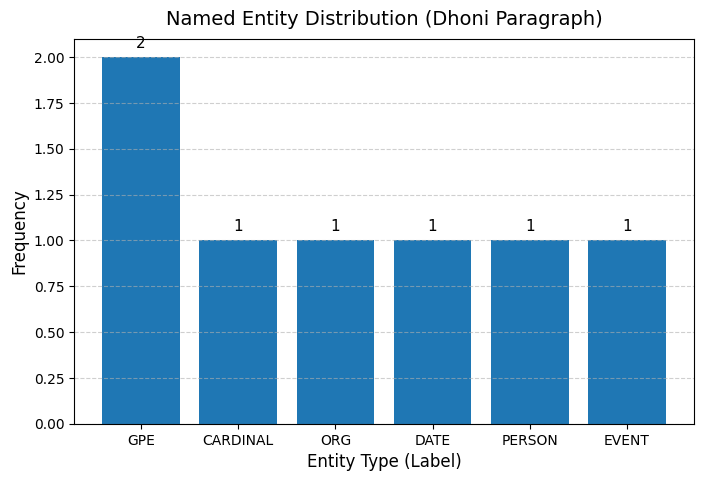

In [11]:
import matplotlib.pyplot as plt

# Group by label and count occurrences
label_counts = df_ents['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(label_counts.index, label_counts.values)

# Add labels and title
plt.title("Named Entity Distribution (Dhoni Paragraph)", fontsize=14, pad=10)
plt.xlabel("Entity Type (Label)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display counts on top of bars
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 0.05, str(count), ha='center', fontsize=11)

plt.show()


### 📊 Interpretation

| Label | Meaning | Example from Text |
|--------|----------|------------------|
| **PERSON** | Human names | M.S. Dhoni |
| **GPE** | Geo-political entities | India, Mumbai |
| **DATE** | Temporal expression | 2011 |
| **EVENT** | Named event | World Cup |

✅ The bar chart makes it easy to **see the dominance of certain entity types**  
in a document — useful for exploratory analysis and model validation.


# 🧭 NER Pipelines: NLTK (Shallow) vs spaCy (Contextual)

Below: two flows showing how the same text passes through **NLTK NER** vs **spaCy NER**.

---

## 🔹 NLTK NER (Shallow, MaxEnt/Rules)

$$
\begin{array}{c}
\boxed{\textbf{Raw Text}} \\[6pt]
\Downarrow\ \text{sent\_tokenize} \\[6pt]
\boxed{\text{Sentences}} \\[6pt]
\Downarrow\ \text{word\_tokenize} \\[6pt]
\boxed{\text{Tokens}} \\[6pt]
\Downarrow\ \text{pos\_tag (Treebank)} \\[6pt]
\boxed{\text{POS Tags}} \\[6pt]
\Downarrow\ \text{ne\_chunk (MaxEnt)} \\[6pt]
\boxed{\text{NER Tree (PERSON/GPE/ORG/\dots)}} \\[6pt]
\Downarrow\ \text{chunk\_walk} \\[6pt]
\boxed{\text{Entities (limited \& shallow)}}
\end{array}
$$

**Characteristics:** rule/statistical chunker, capitalization-heavy, limited labels, weaker on dates/events, may misclassify sentence-initial capitals.

---

## 🔹 spaCy NER (Contextual, Neural)

$$
\begin{array}{c}
\boxed{\textbf{Raw Text}} \\[6pt]
\Downarrow\ \text{nlp() pipeline} \\[6pt]
\boxed{\text{Tokenizer (subword/lexeme)}} \\[6pt]
\Downarrow\ \text{Contextual Encoder (CNN/BiLSTM/Transformer)} \\[6pt]
\boxed{\text{Contextual Token Reps}} \\[6pt]
\Downarrow\ \text{NER Head (transition-based / CRF-like)} \\[6pt]
\boxed{\text{Entity Spans with Labels}} \\[6pt]
\Downarrow\ \text{doc.ents} \\[6pt]
\boxed{\text{Entities (PERSON, GPE, DATE, EVENT, \dots)}}
\end{array}
$$

**Characteristics:** context-aware sequences, robust multi-word entities, better DATE/EVENT detection, fewer capitalization errors.

---

## 🧮 Modeling View (Why spaCy Wins)

**NLTK (shallow):**
$$
\text{label}(w) \approx f(\text{word shape},\ \text{POS},\ \text{nearby tokens})
$$

**spaCy (contextual):**
$$
\hat{y}=\arg\max_{y} P(y\mid x),\qquad
P(y\mid x)=\frac{1}{Z(x)}\exp\!\Big(\sum_i \theta\cdot f(y_{i-1},y_i,x,i)\Big)
$$

The contextual encoder supplies rich features \(x\), enabling **DATE** (e.g., “2011”) and **EVENT** (e.g., “World Cup”) to be recognized reliably.

---

## ✅ Practical Takeaway

- Use **NLTK NER** only for quick demos or tiny pipelines.  
- Prefer **spaCy** (or HF Transformers) for production-quality NER on modern text.
